In [18]:
import networkx as nx
import pandas as pd
import numpy as np
from collections import Counter
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import StringIO

In [20]:
def get_city_data():
    # Source: https://worldpopulationreview.com/cities
    city_url = 'https://worldpopulationreview.com/cities'
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    try:
        response = requests.get(city_url, headers=headers)
        response.raise_for_status()
        tables = pd.read_html(StringIO(response.text))
        df_cities = tables[0]
        # Clean up city names to remove extra details
        cities = df_cities['City'].str.split(',').str[0].tolist()
        print(f"Successfully scraped {len(df_cities)} cities.")
        return cities[:500]
    except requests.exceptions.RequestException as e:
        print(f"An error occurred during scraping: {e}")
    except IndexError:
        print("Could not find the expected table on the page.")
    return []

cities = get_city_data()
if cities:
    print(f"Using the top {len(cities)} most populated cities for the graph.")

Successfully scraped 822 cities.
Using the top 500 most populated cities for the graph.


In [21]:
city_graph = nx.DiGraph()
if cities:
    city_graph.add_nodes_from(cities)
    city_graph.add_edges_from([(c1, c2) for c1, c2 in itertools.product(cities, repeat=2) if c1 != c2 and c1.lower()[-1] == c2.lower()[0]])
    print(f"City graph created with {city_graph.number_of_nodes()} nodes and {city_graph.number_of_edges()} edges.")
else:
    print("City list is empty. Graph not created.")

City graph created with 498 nodes and 9209 edges.


In [22]:
def create_clean_interactive_graph(G):
    pos = nx.kamada_kawai_layout(G)

    edge_x, edge_y = [], []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.4, color='#888'),
        hoverinfo='none',
        mode='lines',
        visible='legendonly',
        name='Connections'
    )

    node_x, node_y, node_hovertext, node_color, node_size = [], [], [], [], []
    for node in G.nodes():
        x, y = pos[node]
        in_degree = G.in_degree(node)
        out_degree = G.out_degree(node)

        node_x.append(x)
        node_y.append(y)

        hovertext = (
            f"{node}"
            f"\n Options From Here: {out_degree}"
            f"\n Paths To Here: {in_degree}"
            f"\n Strategic Value: {out_degree - in_degree}"
        )
        node_hovertext.append(hovertext)
        node_color.append(out_degree - in_degree)
        node_size.append(5 + (in_degree + out_degree) / 2)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        text=node_hovertext,
        marker=dict(
            showscale=True,
            colorscale='RdYlGn',

            color=node_color,
            size=node_size,
            colorbar=dict(
                thickness=15,
                title='Strategic Value',
                xanchor='left',
                titleside='right'
            ),
            line_width=1,
            line_color='black'
        ),
        name='Countries'
    )

    fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Atlas Game: Strategic Map of Countries',
                titlefont_size=20,
                showlegend=True,
                legend_title_text='Toggle View',
                legend=dict(
                    x=0.01,
                    y=0.99,
                    xanchor='left',
                    yanchor='top'
                ),
                hovermode='closest',
                margin=dict(b=5, l=5, r=5, t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                plot_bgcolor='white',
                height=700,
                width=1000
            )
    )

    fig.show()

create_clean_interactive_graph(city_graph)



In [23]:
def perform_analysis(G):
    analysis_results = {
        'in_degrees': dict(G.in_degree),
        'out_degrees': dict(G.out_degree),
        'betweenness': nx.betweenness_centrality(G),
        'pagerank': nx.pagerank(G),
        'sccs': list(nx.strongly_connected_components(G))
    }
    analysis_results['dead_ends'] = [n for n, d in analysis_results['out_degrees'].items() if d == 0]
    start_letters = Counter(c[0].lower() for c in G.nodes())
    end_letters = Counter(c[-1].lower() for c in G.nodes())
    all_letters = sorted(list(set(start_letters.keys()) | set(end_letters.keys())))
    advantage = {l: start_letters.get(l, 0) - end_letters.get(l, 0) for l in all_letters}
    analysis_results.update({
        'start_letters': start_letters, 'end_letters': end_letters,
        'all_letters': all_letters, 'letter_advantage': advantage
    })
    return analysis_results

In [30]:
def generate_strategic_report(G, analysis_results):
    name = "City"

    print(f" COMPREHENSIVE STRATEGIC ANALYSIS: {name.upper()} GRAPH")


    # Graph Density and Basic Structure
    density = nx.density(G)
    avg_degree = np.mean(list(dict(G.degree).values()))
    print(f"\n Basic Structure & Density")
    print(f"  - Nodes: {G.number_of_nodes()} | Edges: {G.number_of_edges()}")
    print(f"  - Graph Density: {density:.4f} (A low value indicates a sparse, strategic graph)")
    print(f"  - Average Degree: {avg_degree:.2f} (A typical place is connected to ~{avg_degree:.0f} other places)")

    # Degree Centrality & Terminal Nodes
    in_degrees = analysis_results['in_degrees'].values()
    out_degrees = analysis_results['out_degrees'].values()
    dead_ends = analysis_results['dead_ends']
    top_in = sorted(analysis_results['in_degrees'].items(), key=lambda x: x[1], reverse=True)[:5]
    top_out = sorted(analysis_results['out_degrees'].items(), key=lambda x: x[1], reverse=True)[:5]

    print(f"\n Degree Centrality & Traps-")
    print(f"  - In-Degree Stats:  Min={min(in_degrees)}, Max={max(in_degrees)}, Mean={np.mean(list(in_degrees)):.2f}")
    print(f"  - Out-Degree Stats: Min={min(out_degrees)}, Max={max(out_degrees)}, Mean={np.mean(list(out_degrees)):.2f}")
    print(f"  - Most Common Destinations (Highest In-Degree):")
    for node, degree in top_in: print(f"    - {node}: {degree} incoming edges")
    print(f"  - Most Powerful Moves (Highest Out-Degree):")
    for node, degree in top_out: print(f"    - {node}: {degree} outgoing options")
    print(f"  - Terminal Nodes ('Dead Ends'): {len(dead_ends)} found")
    if dead_ends: print(f"    - Examples: {', '.join(dead_ends[:5])}")

    # Betweenness Centrality
    betweenness = analysis_results['betweenness']
    top_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:5]
    print(f"\n Betweenness Centrality")
    print(f"  - Centrality Stats: Min={min(betweenness.values()):.4f}, Max={max(betweenness.values()):.4f}, Mean={np.mean(list(betweenness.values())):.4f}")
    print(f"  - Top 5 Bridge Nodes:")
    for node, score in top_betweenness: print(f"    - {node}: {score:.4f}")

    # PageRank Centrality
    pagerank = analysis_results['pagerank']
    top_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:5]
    print(f"\n PageRank")
    print(f"  - PageRank Stats: Min={min(pagerank.values()):.4f}, Max={max(pagerank.values()):.4f}, Mean={np.mean(list(pagerank.values())):.4f}")
    print(f"  - Top 5 Influential Nodes:")
    for node, score in top_pagerank: print(f"    - {node}: {score:.4f}")

    # Strongly Connected Components (SCCs)
    sccs = analysis_results['sccs']
    largest_scc = max(sccs, key=len) if sccs else []
    trivial_sccs = [s for s in sccs if len(s) == 1]
    print(f"\n Structural Cohesion")
    print(f"  - Total Components Found: {len(sccs)}")
    print(f"  - Size of Largest SCC ('The Core Game'): {len(largest_scc)} nodes ({len(largest_scc)/G.number_of_nodes():.1%})")
    print(f"  - Trivial Components (Size 1): {len(trivial_sccs)} (These nodes are on dead-end paths)")

    # Letter frequency Analysis
    start_letters = analysis_results['start_letters']
    end_letters = analysis_results['end_letters']
    advantage = analysis_results['letter_advantage']
    best_letters = sorted(advantage.items(), key=lambda x: x[1], reverse=True)[:5]
    worst_letters = sorted(advantage.items(), key=lambda x: x[1])[:5]
    alphabet = "abcdefghijklmnopqrstuvwxyz"
    start_coverage = len(start_letters) / len(alphabet)
    end_coverage = len(end_letters) / len(alphabet)
    print(f"\n Letter Freq ")
    print(f"  - Starting Letter Coverage: {len(start_letters)} of 26 letters used ({start_coverage:.1%})")
    print(f"  - Ending Letter Coverage:   {len(end_letters)} of 26 letters used ({end_coverage:.1%})")
    print("  - Safest Letters to End On (Highest Advantage):")
    for letter, score in best_letters: print(f"    - '{letter.upper()}': +{score} net advantage")
    print("  - Most Risky Letters to End On (Highest Disadvantage):")
    for letter, score in worst_letters: print(f"    - '{letter.upper()}': {score} disadvantage")

In [25]:
def create_matplotlib_dashboard(G, analysis_results, name="City"):
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle(f'Strategic Analysis Dashboard for {name} Graph', fontsize=20, fontweight='bold')

    in_degrees = list(analysis_results['in_degrees'].values())
    ax1.hist(in_degrees, bins=20, color='skyblue', edgecolor='black')
    ax1.set_title('In-Degree Distribution\n(How often places can be named)', fontweight='bold')
    ax1.set_xlabel('In-Degree'); ax1.set_ylabel('Number of Places')
    ax1.axvline(np.mean(in_degrees), color='red', linestyle='--', label=f'Mean: {np.mean(in_degrees):.1f}'); ax1.legend()

    out_degrees = list(analysis_results['out_degrees'].values())
    ax2.hist(out_degrees, bins=20, color='lightcoral', edgecolor='black')
    ax2.set_title('Out-Degree Distribution\n(Options available after naming)', fontweight='bold')
    ax2.set_xlabel('Out-Degree'); ax2.set_ylabel('Number of Places')
    ax2.axvline(np.mean(out_degrees), color='red', linestyle='--', label=f'Mean: {np.mean(out_degrees):.1f}'); ax2.legend()

    all_letters = analysis_results['all_letters']
    start_counts = [analysis_results['start_letters'].get(l, 0) for l in all_letters]
    end_counts = [analysis_results['end_letters'].get(l, 0) for l in all_letters]
    x = np.arange(len(all_letters)); width = 0.35
    ax3.bar(x - width/2, start_counts, width, label='Starting Letters', color='darkcyan')
    ax3.bar(x + width/2, end_counts, width, label='Ending Letters', color='orange')
    ax3.set_title('Letter Frequency: Starting vs Ending', fontweight='bold')
    ax3.set_xlabel('Letters'); ax3.set_ylabel('Count')
    ax3.set_xticks(x); ax3.set_xticklabels([l.upper() for l in all_letters], rotation=90); ax3.legend()

    adv = analysis_results['letter_advantage']
    letters, advantages = sorted(adv.keys()), [adv[l] for l in sorted(adv.keys())]
    colors = ['g' if val > 0 else 'r' if val < 0 else 'gray' for val in advantages]
    ax4.bar(letters, advantages, color=colors)
    ax4.set_title('Strategic Letter Advantage', fontweight='bold')
    ax4.set_xlabel('Letter Your Turn Ends On'); ax4.set_ylabel('Net Options (Starts - Ends)')
    ax4.axhline(0, color='black', linewidth=0.8); ax4.tick_params(axis='x', rotation=90)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

In [26]:
class AtlasGameAdvisor:
    def __init__(self, graph, analysis_results):
        self.graph = graph
        self.analysis = analysis_results
        self.used_items = set()
        self.item_scores = self._calculate_scores()

    def _calculate_scores(self):
        scores = {}
        out_degrees = self.analysis['out_degrees']
        pagerank = self.analysis['pagerank']
        betweenness = self.analysis['betweenness']
        for item in self.graph.nodes():
            score = (out_degrees.get(item, 0) * 2) + (pagerank.get(item, 0) * 500) + (betweenness.get(item, 0) * 200)
            if out_degrees.get(item, 0) == 0: score -= 100
            scores[item] = score
        return scores

    def recommend_moves(self, last_item):
        valid_moves = [s for s in self.graph.successors(last_item) if s not in self.used_items]
        if not valid_moves: return "Opponent is trapped! You win!"
        return sorted([(move, self.item_scores.get(move, 0)) for move in valid_moves], key=lambda x: x[1], reverse=True)

    def mark_used(self, item): self.used_items.add(item)
    def reset(self): self.used_items.clear()

def start_interactive_session(advisor, graph_nodes):
    print("\nATLAS GAME STRATEGY ADVISOR (COUNTRIES)\n")
    print("Enter opponent's move to get strategic advice. Commands: 'reset', 'used', 'quit'")
    while True:
        user_input = input("\n> Opponent played: ").strip()
        if user_input.lower() == 'quit': print("Exiting advisor."); break
        if user_input.lower() == 'reset': advisor.reset(); print("Game has been reset."); continue
        if user_input.lower() == 'used': print("Used:", sorted(list(advisor.used_items)) if advisor.used_items else "None"); continue
        matches = [c for c in graph_nodes if c.lower().startswith(user_input.lower())]
        if not matches: print(f"Sorry, couldn't find '{user_input}'."); continue
        selected_item = matches[0]
        if selected_item in advisor.used_items: print(f"'{selected_item}' has already been used."); continue
        advisor.mark_used(selected_item)
        print(f"Opponent's move '{selected_item}' marked as used.")
        recommendations = advisor.recommend_moves(selected_item)
        if isinstance(recommendations, str): print(f"\n{recommendations}"); break
        print("\n Recommended Moves (Best to Worst)")
        for i, (move, score) in enumerate(recommendations[:5]):
            dead_end_tag = " (WINNING TRAP!)" if advisor.analysis['out_degrees'].get(move, 0) == 0 else ""
            print(f"{i+1}. {move}{dead_end_tag}")
        if recommendations:
            best_move = recommendations[0][0]
            choice = input(f"Execute best move '{best_move}'? (y/n): ").strip().lower()
            if choice == 'y':
                advisor.mark_used(best_move)
                print(f"'{best_move}' marked as used. Your turn is over.")

 COMPREHENSIVE STRATEGIC ANALYSIS: CITY GRAPH

 Basic Structure & Density
  - Nodes: 498 | Edges: 9209
  - Graph Density: 0.0372 (A low value indicates a sparse, strategic graph)
  - Average Degree: 36.98 (A typical place is connected to ~37 other places)

 Degree Centrality & Traps-
  - In-Degree Stats:  Min=0, Max=82, Mean=18.49
  - Out-Degree Stats: Min=3, Max=45, Mean=18.49
  - Most Common Destinations (Highest In-Degree):
    - Ahmedabad: 82 incoming edges
    - Abidjan: 82 incoming edges
    - Antananarivo: 82 incoming edges
    - Asuncion: 82 incoming edges
    - Athens: 82 incoming edges
  - Most Powerful Moves (Highest Out-Degree):
    - Dar es Salaam: 45 outgoing options
    - Khartoum: 45 outgoing options
    - Thiruvananthapuram: 45 outgoing options
    - Birmingham: 45 outgoing options
    - Belem: 45 outgoing options
  - Terminal Nodes ('Dead Ends'): 0 found

 Betweenness Centrality
  - Centrality Stats: Min=0.0000, Max=0.0684, Mean=0.0028
  - Top 5 Bridge Nodes:
    - Ga

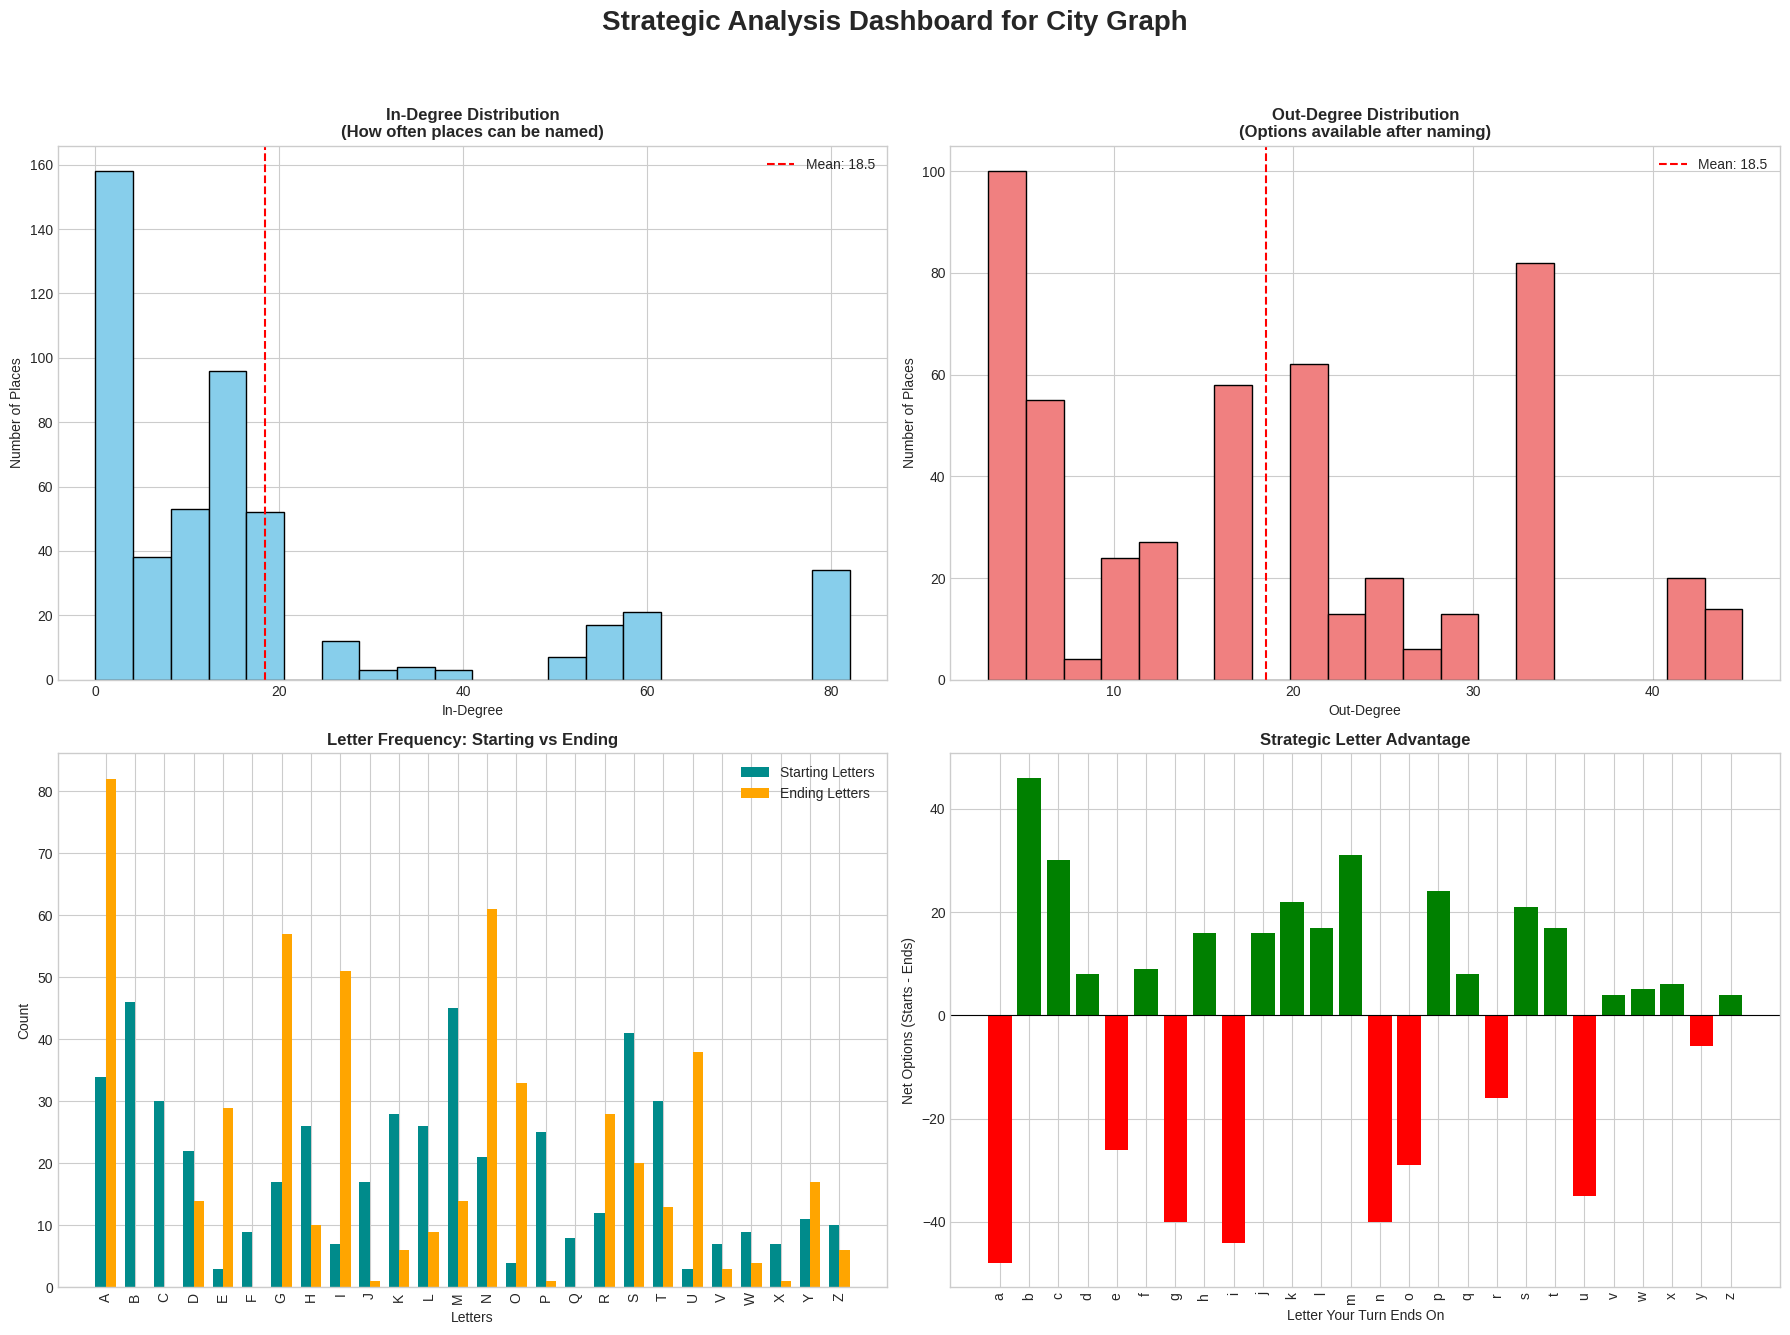

In [31]:
city_analysis_results = perform_analysis(city_graph)
generate_strategic_report(city_graph, city_analysis_results)
create_matplotlib_dashboard(city_graph, city_analysis_results, name="City")
city_advisor = AtlasGameAdvisor(city_graph, city_analysis_results)


In [37]:
start_interactive_session(city_advisor, list(city_graph.nodes()))


ATLAS GAME STRATEGY ADVISOR (COUNTRIES)

Enter opponent's move to get strategic advice. Commands: 'reset', 'used', 'quit'

> Opponent played: Delhi
Opponent's move 'Delhi' marked as used.

 Recommended Moves (Best to Worst)
1. Istanbul
2. Islamabad
3. Ibadan
4. Incheon
5. Izmir
Execute best move 'Istanbul'? (y/n): y
'Istanbul' marked as used. Your turn is over.

> Opponent played: Lucknow
Opponent's move 'Lucknow' marked as used.

 Recommended Moves (Best to Worst)
1. Wuhan
2. Weifang
3. Wenling
4. Warsaw
5. Wuxi
Execute best move 'Wuhan'? (y/n): Nagpur

> Opponent played: Nagpur
Opponent's move 'Nagpur' marked as used.

 Recommended Moves (Best to Worst)
1. Rajkot
2. Rabat
3. Riyadh
4. Ruian
5. Raipur
Execute best move 'Rajkot'? (y/n): y
'Rajkot' marked as used. Your turn is over.

> Opponent played: quit
Exiting advisor.
